# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab/'
path.append(root)

amazon_en_label = 'amazon_en'
amazon_de_label = 'amazon_de'
organic_label = 'organic'

data_location = 'data/data-with-embeddings/not-contextualized-embeddings/BERT-base-uncased/'
embedding_dim = 768

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def read_data(label, splits):
  if label is None:
    return None

  for split in splits:
    path = root + data_location + label + f'_{split}.json'
    with open(path) as json_file:      
        data_df = json_file.read() 
        data_df = json.loads(data_df)
        yield pd.DataFrame(data_df)

In [5]:
organic_train_df, organic_test_df = read_data(organic_label, ['train', 'test'])

FileNotFoundError: ignored

In [ ]:
def drop(df, column, value):
  print(f'----> size before {len(df)}')
  idx = df[column] != value
  print(f'----> size after {idx.sum()}')
  return df[idx]

drop_neutral = True

if drop_neutral:
  print('======DROPPING NEUTRAL CLASS======')
  print('organic: train')
  organic_train_df = drop(organic_train_df, 'sentence_sentiment', '0')
  print('organic: test')
  organic_test_df = drop(organic_test_df, 'sentence_sentiment', '0')

======DROPPING NEUTRAL CLASS======
----> size before: 5084
----> size after:  3111


In [ ]:
if drop_neutral:
  sentiment_classes = {'n': 0, 'p': 1}
  sentiment_labels = {0 : 'n', 1 : 'p'} 
else:
  sentiment_classes = {'n': 0, '0': 1, 'p': 2}
  sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'}

last_label = str(embedding_dim - 1)

organic_embeddings = torch.Tensor(
    organic_df.loc[:, '0':last_label].values).to(device)
organic_sentiments = torch.Tensor(organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)
organic_dataset = dataset.DocumentDataset(tuple(organic_embeddings.unsqueeze(1)),
                                          organic_sentiments)

In [ ]:
datasets = {'organic': organic_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(organic) = 3111


In [ ]:
def split(dataset_to_split, splits=(0.8, 0.1, 0.1)):
  assert(sum(splits) == 1)
  n_comments = len(dataset_to_split)
  n_val = int(splits[1] * n_comments)
  n_test = int(splits[2] * n_comments)
  n_train = n_comments - n_val - n_test

  return utils.data.random_split(dataset_to_split, (n_train, n_val, n_test))

organic_train, organic_val, organic_test = split(organic_dataset, splits=(0.8, 0.1, 0.1))

In [ ]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.5
params.dropout_att = 0.5
params.dropout_seg = 0.5
params.classes_nb = 3 - drop_neutral

In [ ]:
def train(milnet, train_set, val_set, batch_size, optim_params, fit_params):
  train_loader = utils.data.DataLoader(train_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(milnet.parameters(), **optim_params)
  criterion = nn.NLLLoss()

  return trainer.fit(milnet, optimizer, criterion, dataloaders, **fit_params)

In [ ]:
def random_search(get_milnet_fn, train_set, param_options, nb_searches, cv,
                  batch_size, nb_epochs, patience):
  n = len(train_set)
  head = [n//cv] * (cv - 1)
  partitions = head + [n - sum(head)]

  best_cum_val_loss = float('inf')
  best_param_dict = None
  best_train_losses_all = None
  best_val_losses_all = None

  param_names = sorted(param_options.keys())
  for i in range(nb_searches):
    param_dict = {name: random.choice(param_options[name]) 
                  for name in param_names}
    
    print(f'run {i + 1: >3}/{nb_searches} -> parameters: ' +
          ", ".join(f'{name} = {param_dict[name]:.2e}' for name in param_names))

    cum_val_loss = 0
    train_losses_all = []
    val_losses_all = []

    folds = utils.data.random_split(train_set, partitions)
    for j, val_fold in enumerate(folds):
      train_folds = utils.data.ConcatDataset(folds[:j] + folds[j+1:])

      fit_params = {'nb_epochs': nb_epochs, 'patience': patience,
                    'print_every': None}

      milnet = get_milnet_fn()
      best_val_loss, train_losses, val_losses = train(milnet, train_folds,
                                                      val_fold, batch_size,
                                                      param_dict, fit_params)
      
      print(f'\tfold {j + 1: >3}/{cv} -> val loss: {best_val_loss:.2e}')
      cum_val_loss += best_val_loss
      train_losses_all.append(train_losses)
      val_losses_all.append(val_losses)

    cum_val_loss /= cv
    print(f'total validation loss = {cum_val_loss}')
    if cum_val_loss < best_cum_val_loss:
      best_cum_val_loss = cum_val_loss
      best_param_dict = param_dict
      best_train_losses_all = train_losses_all
      best_val_losses_all = val_losses_all

  return (best_cum_val_loss, best_param_dict, best_train_losses_all,
          best_val_losses_all)


get_milnet_fn = lambda: model.MilNet(params, train_embeddings=False).to(device)
param_options = {'lr': [i*5e-4 for i in range(1, 50)],
                 'weight_decay': [i*1e-3 for i in range(1, 50)]}

n = len(organic_train)
data_piece, _ = utils.data.random_split(organic_train, [n // 5, n - n // 5])
nb_searches = 20
cv = 5
batch_size = 32
nb_epochs = 40
patience = 40

(best_cum_val_loss, best_param_dict, best_train_losses_all,
          best_val_losses_all) = random_search(get_milnet_fn, data_piece,
                                               param_options, nb_searches, cv,
                                               batch_size, nb_epochs, patience)

run   1/20 -> parameters: lr = 2.20e-02, weight_decay = 3.00e-03
	fold   1/5 -> val loss: 2.91e-02
	fold   2/5 -> val loss: 2.68e-02
	fold   3/5 -> val loss: 2.51e-02
	fold   4/5 -> val loss: 2.90e-02
	fold   5/5 -> val loss: 2.73e-02
total validation loss = 0.02745920815050401
run   2/20 -> parameters: lr = 2.40e-02, weight_decay = 7.00e-03
	fold   1/5 -> val loss: 2.75e-02
	fold   2/5 -> val loss: 2.66e-02
	fold   3/5 -> val loss: 2.75e-02
	fold   4/5 -> val loss: 2.76e-02
	fold   5/5 -> val loss: 2.76e-02
total validation loss = 0.02734357324513522
run   3/20 -> parameters: lr = 7.50e-03, weight_decay = 4.30e-02
	fold   1/5 -> val loss: 2.77e-02
	fold   2/5 -> val loss: 2.74e-02
	fold   3/5 -> val loss: 2.82e-02
	fold   4/5 -> val loss: 2.89e-02
	fold   5/5 -> val loss: 2.88e-02
total validation loss = 0.028200134714578266
run   4/20 -> parameters: lr = 2.45e-02, weight_decay = 4.80e-02
	fold   1/5 -> val loss: 3.20e-02
	fold   2/5 -> val loss: 3.16e-02
	fold   3/5 -> val loss: 3.08

In [ ]:
best_param_dict, params.classes_nb

({'lr': 0.024, 'weight_decay': 0.007}, 3)

In [ ]:
optim_params = {'lr': 5e-3, 'weight_decay': 1e-2}
fit_params = {'nb_epochs': 200, 'patience': 50, 'print_every': 10}
milnet = model.MilNet(params, train_embeddings=False).to(device)
best_loss, train_losses, val_losses = train(milnet, organic_train, organic_val,
                                            batch_size=128,
                                            optim_params=optim_params,
                                            fit_params=fit_params)

Epoch  10/200 -> train loss: 7.21e-03, accuracy: 52.31%
Epoch  10/200 -> val loss: 5.28e-03, accuracy: 45.28%
Epoch  20/200 -> train loss: 7.08e-03, accuracy: 53.15%
Epoch  20/200 -> val loss: 5.22e-03, accuracy: 45.28%
Epoch  30/200 -> train loss: 7.09e-03, accuracy: 52.53%
Epoch  30/200 -> val loss: 5.17e-03, accuracy: 44.88%
Epoch  40/200 -> train loss: 6.94e-03, accuracy: 53.39%
Epoch  40/200 -> val loss: 5.11e-03, accuracy: 45.87%
Epoch  50/200 -> train loss: 6.98e-03, accuracy: 54.79%
Epoch  50/200 -> val loss: 5.04e-03, accuracy: 47.44%
Epoch  60/200 -> train loss: 6.92e-03, accuracy: 54.38%
Epoch  60/200 -> val loss: 5.11e-03, accuracy: 46.06%
Epoch  70/200 -> train loss: 6.88e-03, accuracy: 54.60%
Epoch  70/200 -> val loss: 5.09e-03, accuracy: 43.90%
Epoch  80/200 -> train loss: 6.86e-03, accuracy: 54.42%
Epoch  80/200 -> val loss: 5.09e-03, accuracy: 45.67%
Epoch  90/200 -> train loss: 7.00e-03, accuracy: 53.61%
Epoch  90/200 -> val loss: 5.24e-03, accuracy: 44.69%
Epoch 100/

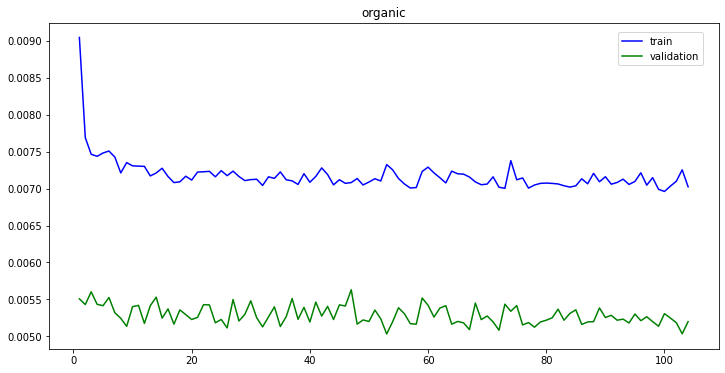

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_organic) = plt.subplots(1, 1, figsize=(12,6))
plot_losses("organic", ax_organic, train_losses, val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [ ]:
torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/base_bert_pure_organic_{params.classes_nb}cl')

In [ ]:
milnet = model.MilNet(params, train_embeddings=False).to(device)
milnet.load_state_dict(torch.load(root + f'/models/milnet/state_dicts/base_bert_pure_organic_{params.classes_nb}cl'))

<All keys matched successfully>

In [ ]:
def get_results(full_set, nb_runs):
  results = []
  n = len(full_set)
  for _ in range(nb_runs):
    _, test_set = utils.data.random_split(full_set, [n - n //10, n//10])
    test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                        shuffle=True,
                                        collate_fn=prepare_batch,
                                        drop_last=True)
    for documents, classes in test_loader:
      predictions = milnet(documents).cpu().numpy()
      results.append((np.argmax(predictions, axis=1), classes.cpu().numpy()))
  
  return results

ORGANIC = 'organic'
results = {}
nb_runs = 20


milnet.eval()
with torch.set_grad_enabled(False):
  results[ORGANIC] = get_results(organic_dataset, nb_runs)

In [ ]:
for dataset_name, run_result in results.items():
  worst_f1 = float('inf')
  mean_f1 = 0
  top1 = None
  labels = None
  for run_top1, run_labels in run_result:
    run_micro = metrics.f1_score(run_labels, run_top1, average="micro")
    run_macro = metrics.f1_score(run_labels, run_top1, average="macro")
    run_f1 = run_micro + run_macro

    mean_f1 += run_f1

    if run_f1 < worst_f1:
      worst_f1 = run_f1
      top1 = run_top1
      labels = run_labels

  print(f'=== {dataset_name} ===')
  print(f'mean F1-score = {mean_f1/nb_runs/2}, worst F1-score = {worst_f1/2}')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== organic ===
mean F1-score = 0.749021630401997, worst F1-score = 0.71323215837344
F1-micro = 0.7138263665594856
F1-macro = 0.7126379501873943

         n    p
    n  121   20
    p   69  101

